#Classification of target geometry using gammatone-filterbank output of echoes
Preys common in echolocating bats' habitat may have different number of glints (a reflecting surface). For example, as a moth flaps its two wings, it may have 1-3 glints at different angle and time. This work is to study if artificial neural network such as convolutional neural network (CNN) can classify echoes based on the number of glints in the target, and to compare the activations of artificial neurons with the spectro-temporal response field (STRF) recorded in bats' brain. This work is collaborated with Prof. Michael Smotherman in Texas A&M, who is responsible for STRF recordings.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pip install tensorflow==2.2.0
#pip install tf-nightly

In [2]:
# Import necessary frameworks
# Import the necessary packages
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from tensorflow.keras import datasets, layers, models, regularizers
from keras.callbacks import Callback
from keras.models import Model

## Load training data and labels. They are generated in MATLAB and saved in .mat format.
allinone.mat contains the time-frequency representations of the echoes from 4 categories of targets - 1-glint, 2-glint, 3-glint, and 4 -glint.
labels.mat contains the labels of above data

In [3]:
datadict = sio.loadmat('/content/drive/My Drive/cnn backup/allinone.mat') # <-- pls change the directory accordingly
labelsdict = sio.loadmat('/content/drive/My Drive/cnn backup/labels2.mat') # <-- pls change the directory accordingly
data = np.array(datadict['glint'])
data = np.expand_dims(data, axis=3) # input size - batch_size, height-freq, width-time, depth-leftear
print(data.shape)
label = np.array(labelsdict['labels'])

label_train, label_test, coch_train, coch_test = train_test_split(label, data, test_size=0.25, shuffle=True, random_state=30)
print(label_train.shape,  label_test.shape)
num_classes = 4
# Construct the CNN architecture
model = models.Sequential()

# conv - 1
model.add(layers.Conv2D(8, (5, 5), padding='same', input_shape=(161,1100,1))) #  CNN takes tensors of shape (image_height, image_width, color_channels)
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(4, 4), strides=(2,2)))
# conv - 2
model.add(layers.Conv2D(16, (5, 5), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(4, 4), strides=(2,2)))
# conv - 3
model.add(layers.Conv2D(32, (5, 5), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(4, 4), strides=(2,2)))
# conv - 4
model.add(layers.Conv2D(64, (5, 5), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(4, 4), strides=(2,2)))

model.add(layers.Flatten())
#model.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(units=num_classes, 
                       use_bias=True, 
                       kernel_regularizer=regularizers.l2(0.2), 
                       activation='softmax'))

model.summary()

(288, 161, 1100, 1)
(216, 1) (72, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 161, 1100, 8)      208       
_________________________________________________________________
batch_normalization (BatchNo (None, 161, 1100, 8)      32        
_________________________________________________________________
activation (Activation)      (None, 161, 1100, 8)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 549, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 79, 549, 16)       3216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 79, 549, 16)       64        
_________________________________________________________________
activation_1 (Activ

[[0]
 [3]
 [0]
 [0]]


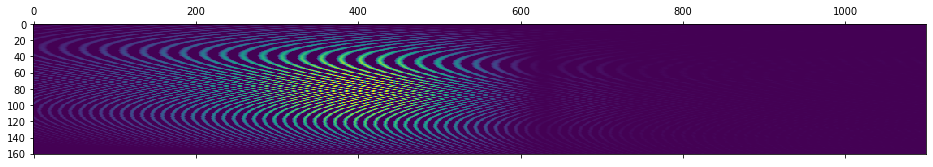

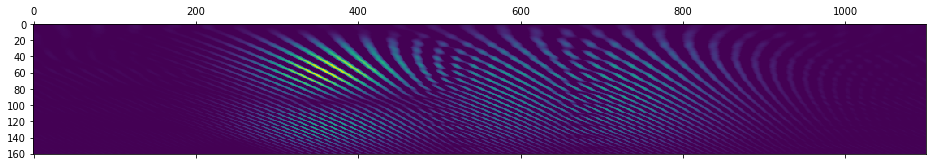

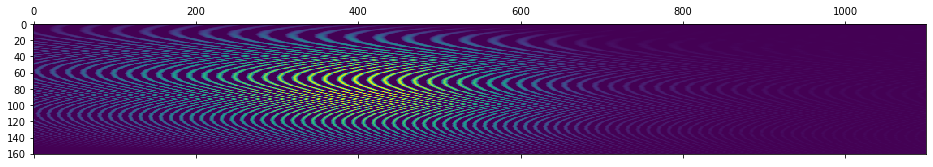

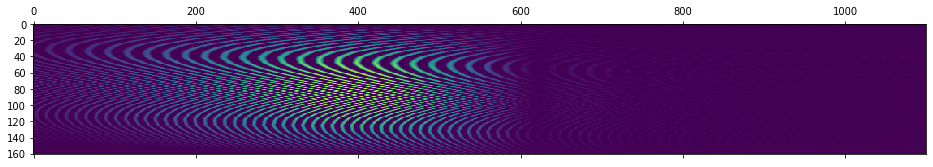

In [4]:

print(label_train[0:4])
plt.matshow(coch_train[0,:,:,0])
plt.matshow(coch_train[1,:,:,0])
plt.matshow(coch_train[2,:,:,0])
plt.matshow(coch_train[3,:,:,0])

# Some notes about choice of loss functions:
 using SparseCategoricalCrossentropy integer-tokens are converted to a one-hot-encoded label **starting at 0**. So it creates it, but it is not in your data. So having two classes you need to provide the labels as 0 and 1. And not -1 and 1. Therefore it is as you write, you can either:

Run it with one-hot encoding using Categorical Crossentropy or
Run it with integer labels 0 and 1 using Sparse Categorical Crossentropy,

In [7]:
# Compile and Train
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', 
#               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), 
#               metrics=['accuracy'])

history = model.fit(coch_train, label_train, epochs=250, 
                    validation_data=(coch_test, label_test))

Epoch 1/250
7/7 [==============================] - 3s 271ms/step - loss: 0.1527 - accuracy: 0.9907 - val_loss: 0.4345 - val_accuracy: 0.8750
Epoch 2/250
7/7 [==============================] - 1s 210ms/step - loss: 0.1610 - accuracy: 0.9954 - val_loss: 0.3340 - val_accuracy: 0.9306
Epoch 3/250
7/7 [==============================] - 1s 212ms/step - loss: 0.1383 - accuracy: 1.0000 - val_loss: 0.2687 - val_accuracy: 0.9583
Epoch 4/250
7/7 [==============================] - 1s 209ms/step - loss: 0.1297 - accuracy: 1.0000 - val_loss: 0.2775 - val_accuracy: 0.9306
Epoch 5/250
7/7 [==============================] - 1s 209ms/step - loss: 0.1268 - accuracy: 1.0000 - val_loss: 0.3093 - val_accuracy: 0.9306
Epoch 6/250
7/7 [==============================] - 1s 211ms/step - loss: 0.1263 - accuracy: 1.0000 - val_loss: 0.2718 - val_accuracy: 0.9444
Epoch 7/250
7/7 [==============================] - 1s 209ms/step - loss: 0.9872 - accuracy: 0.8565 - val_loss: 2.4484 - val_accuracy: 0.7222
Epoch 8/250
7

3/3 - 0s - loss: 0.2046 - accuracy: 0.9583


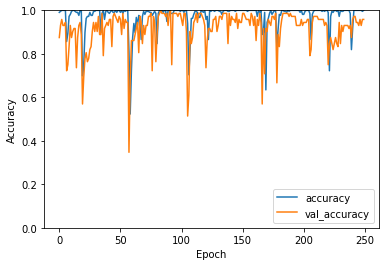

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(coch_test, label_test, verbose=2)